In [12]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

from tqdm import tqdm

# This code solves the energy balance model used in Roe et al. (Nat. Geosci., 2015)
# The model operates in perturbation mode (i.e., the anomaly with respect to a prescribed climatology):
# You can specify:-
# the pattern of climate forcing, Rf
# the pattern of climate feedbacks, -B
# the ocean heat uptake, G
# the diffusivity, D
# whether you diffuse moist static energy, or just sensible heat

In [13]:
#time step in fraction of year
delt=1./500000;
NMAX=10000000;

#set up x array (x = sine of latitude).
jmx=101; #101
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx)
phi = np.arcsin(x)*180/np.pi;

# I think this C = rho * c * h_ml /(pi*1e7).
# this is consistent with a ~1m layer of dirt
# Note - heat capacity over LAND for fast convergence
Cl = 0.2; # units: J /(m2 K)

In [14]:
# Moisture parameters
relhum = 0.8;   # relative humidity
eps = 0.622;    # moisture coonstant
psfc = 9.8e4;   # (Pa)
e0 = 611.2;     # vap. press (Pa)
a = 17.67; b = 243.5;   # sat vap constants !!T must be in temperature
L = 2.45e6;         # latent heat of vaporization (J kg-1)
cp = 1004;          # (J kg-1 K-1)

In [15]:
# magnitude of diffusivity
Dmag = 0.2598; # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1); # diffusivity for MSE

In [16]:
# For dry energy balance model, uncomment these lines:
#Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
#D=Dmag*np.ones(jmx+1); # diffusivity for sensible (cp*T)
#relhum = 0;  # switch off humidity

In [17]:
#load in the climatological temperature from ERA-Interim for the control climate
matLabData = io.loadmat('ERAtemperature.mat') #loads matlab file as a dictionary with some metadata
#matLabData.keys() #tell me what's in the dictionary
lat = np.asarray(matLabData['lat'])
T_ctrl = np.asarray(matLabData['T'])
T_ctrl = 0.5*(T_ctrl+np.flipud(T_ctrl)); # average N & S hemispheres for symmetry
T_ctrl.shape
from scipy.interpolate import griddata
T_ctrl = griddata(np.sin(np.deg2rad(lat)), T_ctrl, x, method='linear') #interp1(sind(lat),T_ctrl,x,'linear');
T_ctrl = np.squeeze(T_ctrl, axis=1)
q = eps*relhum/psfc*e0*np.exp(a*(T_ctrl)/(b+(T_ctrl)));  #q=q(:); # here T is in oC. q is g kg-1
theta_e_ctrl = 1/cp*(cp*((T_ctrl)+273.15) + L*q); #theta is mse divided by cp. note units of Kelvin are needed!!!

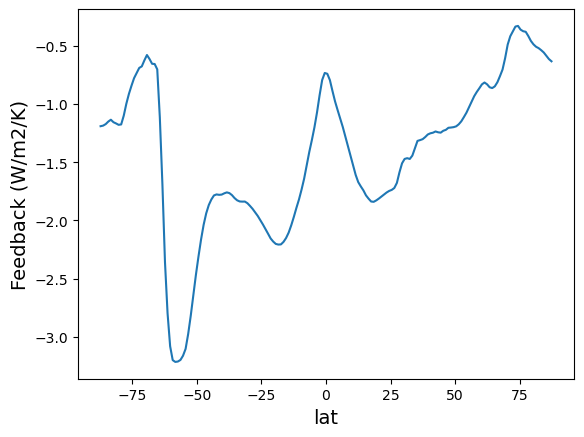

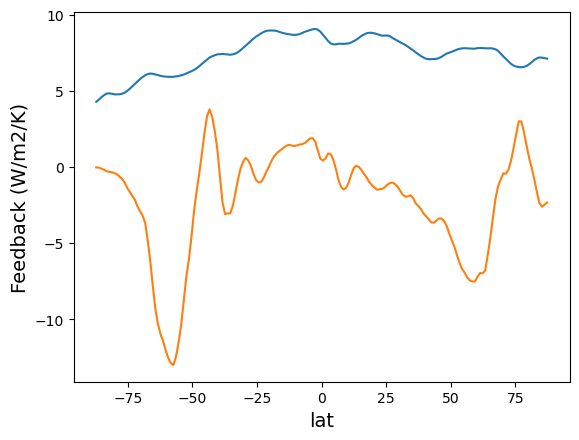

In [18]:
#--------------------------------------------------------------
# Choose a pattern of feedbacks (-B), forcing and ocean heat uptake.
# Default is CMIP5-mean pattern, but you can uniform feedback and forcing below

#CMIP5 ensemble-mean feedback and forcing values from 4xCO2 simulations (taken at year 100)
matLabData = io.loadmat('CMIP5_Rf_G_lambda.mat') #feedback, forcing and heat uptake for 11 models
CMIP5_lat = np.asarray(matLabData['CMIP5_lat']) #latitude
CMIP5_T = np.asarray(matLabData['CMIP5_T']) #Temperature change
CMIP5_lambda = np.asarray(matLabData['CMIP5_lambda']) #Radiative feedback
CMIP5_Rf = np.asarray(matLabData['CMIP5_Rf']) #Radiative forcing
CMIP5_G = np.asarray(matLabData['CMIP5_G']) #Ocean heat uptake
CMIP5_names = np.asarray(matLabData['CMIP5_names']) #names for the 11 CMIP5 models

B = -griddata(CMIP5_lat,np.mean(CMIP5_lambda,axis=1),phi, method='linear'); #taking average over the 13 CMIP5 models
R_frc = griddata(CMIP5_lat,np.mean((CMIP5_Rf + CMIP5_G),axis=1),phi, method='linear'); #CO2 forcing Rf plus ocean heat uptake G

plt.plot(CMIP5_lat,np.mean(CMIP5_lambda,axis=1))
plt.xlabel('lat', fontsize=14)
plt.ylabel('Feedback (W/m2/K)', fontsize=14)
plt.show()

plt.plot(CMIP5_lat,np.mean(CMIP5_Rf,axis=1))
plt.plot(CMIP5_lat,np.mean(CMIP5_G,axis=1))
plt.xlabel('lat', fontsize=14)
plt.ylabel('Feedback (W/m2/K)', fontsize=14)
plt.show()

In [19]:
# For flat forcing, uniform feedbacks, no ocean heat uptake, uncomment these lines:
#R_frc = 7.8; # uniform forcing in [W/m2] for a quadrupling of CO2, 7.8 value taken as global average of CMIP5
#B = 1.4*np.ones(x.size) # uniform feedback [W/m2/K], 1.4 value taken as average of CMIP5
#print('Using flat forcing and feedbacks instead of CMIP5!!')

In [20]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
    M[j,j-1] = lam[j]

    M[j,j]   = - (lam[j+1]+lam[j])

    M[j,j+1] = lam[j+1]


Mdiv = M; #Divergence matrix 

In [21]:
# Now solve climate change experiment
#set up inital T profile 
T = 5*np.ones(x.size);
Tinit=T;
Tglob = np.mean(Tinit);
#T.shape

In [22]:
# Timestepping loop
for j in tqdm(range(0, NMAX-1)):

    #print(np.mean(T)) 

    # spec. hum, and theta_e
    q = eps*relhum/psfc*e0*np.exp(a*(T+T_ctrl)/(b+(T+T_ctrl))); # here T is in oC. q is g kg-1

    theta_e = 1/cp*(cp*((T+T_ctrl)+273.15) + L*q); # note units of Kelvin are needed!!!

    theta_e_pert = theta_e-theta_e_ctrl; #anomalous theta_e

    # Calculate new T from Source and Sink terms.
    # Diffuse anomalous moist static energy (theta_e_pert)
    dT = delt/Cl*(R_frc - (B*T) + np.matmul(Mdiv,theta_e_pert));

    T = T + dT; 

    #print(np.mean(T))

    # Check to see if global mean energy budget has converged:   
    Fglob=np.mean(R_frc - (B*T))

    if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
        break  
print(Fglob) 

  5%|█▍                             | 473225/9999999 [00:16<05:40, 27987.77it/s]

-0.0009999867281601


In [23]:
print(np.mean(T)) #temperature anomaly
divF_pert = -np.matmul(Mdiv,theta_e_pert);
h_pert = theta_e_pert*cp;

4.15256589178845


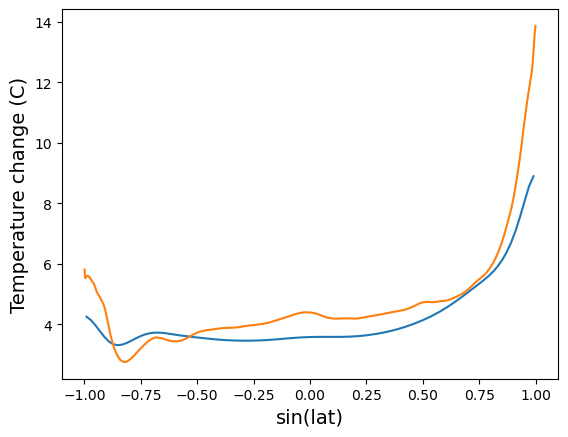

In [24]:
plt.plot(x,T)
plt.plot(np.sin(np.deg2rad(CMIP5_lat)),np.mean(CMIP5_T,axis=1)) #compare to CMIP5 average warming
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()


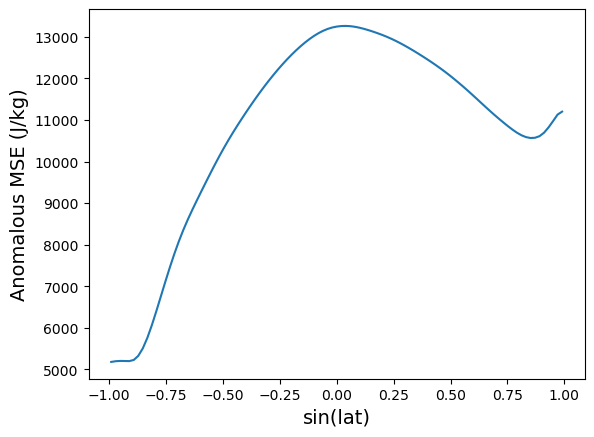

In [25]:
plt.plot(x,h_pert)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Anomalous MSE (J/kg)', fontsize=14)
plt.show()

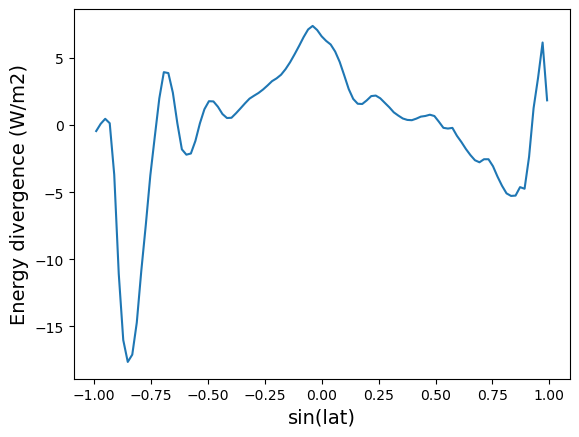

In [26]:
plt.plot(x,divF_pert)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Energy divergence (W/m2)', fontsize=14)
plt.show()